In [1]:
from selenium import webdriver
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# 통계모델들...
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# windows 용 한글 폰트 오류 해결
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc("font", family = font_name)

In [3]:
# 크롤링하기 

#driver = webdriver.Chrome()
#url = 'https://www.google.com'
#driver.get(url)

# 카테고리 : 클래스 class = "category"
# 제목 : 클래스 옆 a 태그
# 구독자 수 :class = subscriber_cnt
# 조회수 : class =  view_cnt
# 비디오 개수 : class = video_cnt

cate = []
title = []
subscriber = []
view = []
video = []



# 1000 개 니까 1 부터 10 page 수
for i in range(1,11): 
    url = f"https://youtube-rank.com/board/bbs/board.php?bo_table=youtube&page={i}#"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
        # 뽑아올 데이터 돔
        cate += soup.select("p.category")
        title += soup.select("p.category + a")
        subscriber += soup.select("td.subscriber_cnt")
        view += soup.select("td.view_cnt")
        video += soup.select("td.video_cnt")
    else : 
        print(response.status_code)


In [4]:
cate_dom = []
title_dom = []
subscriber_dom = []
view_dom = []
video_dom = []

# 배열에 하나하나 저장하기
for cat, tit, sub,v,vd in zip(cate,title,subscriber,view,video):
    cate_dom.append(cat.text.strip())
    title_dom.append(tit.text.strip())
    subscriber_dom.append(sub.text)
    view_dom.append(v.text)
    video_dom.append(vd.text)


In [82]:
# 데이터 프레임에 저장
youtube_df = pd.DataFrame({
'cate': cate_dom,
 'title':title_dom,
 'subscriber':subscriber_dom,
 'view':view_dom,
 'video':video_dom,
})
youtube_df.head()
    

,cate,title,subscriber,view,video
0,[BJ/인물/연예인],김프로KIMPRO,1억2400만,1145억9102만,"3,594개"
1,[음악/댄스/가수],BLACKPINK,9920만,403억6448만,637개
2,[음악/댄스/가수],BANGTANTV,8160만,260억5213만,"2,930개"
3,[음악/댄스/가수],HYBE LABELS,7890만,420억4296만,"2,896개"
4,[미분류],Justin Bieber,7640만,363억0715만,278개


In [83]:
youtube_df.isna().sum()

cate          0
title         0
subscriber    0
view          0
video         0
dtype: int64

# 데이터 전처리하기

In [84]:
youtube_df.dtypes

cate          object
title         object
subscriber    object
view          object
video         object
dtype: object

In [85]:
youtube_df

,cate,title,subscriber,view,video
0,[BJ/인물/연예인],김프로KIMPRO,1억2400만,1145억9102만,"3,594개"
1,[음악/댄스/가수],BLACKPINK,9920만,403억6448만,637개
2,[음악/댄스/가수],BANGTANTV,8160만,260억5213만,"2,930개"
3,[음악/댄스/가수],HYBE LABELS,7890만,420억4296만,"2,896개"
4,[미분류],Justin Bieber,7640만,363억0715만,278개
...,...,...,...,...,...
995,[뉴스/정치/사회],뉴스데일리베스트,99만,3억1520만,"4,455개"
996,[영화/만화/애니],구불,99만,2억9263만,391개
997,[미분류],Again 가요톱10 : KBS KPOP Classic,99만,10억9400만,"10,688개"
998,[미분류],뚜식이,99만,8억0500만,923개


In [86]:
#youtube_df.to_excel("youtube_rank.xlsx", index = False)

In [87]:
# subscriber ,view, video 를 int 형으로 변경하기 
# 1. "억" 기준으로 잘라서 100000000 곱해주기
# 2. "만" 기준으로 잘라서 10000 곱해주기 
# 3. 둘이 더하기 

# 1. subscribe , view 

drop_index = youtube_df[~youtube_df["subscriber"].str.contains('억')]
youtube_df["subscriber_int"] = drop_index["subscriber"].str.replace("만","").astype(int) * 10000
youtube_df["subscriber_int"] = youtube_df["subscriber_int"].fillna(-1).astype('Int64').replace({-1: np.nan})


In [88]:
youtube_df

,cate,title,subscriber,view,video,subscriber_int
0,[BJ/인물/연예인],김프로KIMPRO,1억2400만,1145억9102만,"3,594개",<NA>
1,[음악/댄스/가수],BLACKPINK,9920만,403억6448만,637개,99200000
2,[음악/댄스/가수],BANGTANTV,8160만,260억5213만,"2,930개",81600000
3,[음악/댄스/가수],HYBE LABELS,7890만,420억4296만,"2,896개",78900000
4,[미분류],Justin Bieber,7640만,363억0715만,278개,76400000
...,...,...,...,...,...,...
995,[뉴스/정치/사회],뉴스데일리베스트,99만,3억1520만,"4,455개",990000
996,[영화/만화/애니],구불,99만,2억9263만,391개,990000
997,[미분류],Again 가요톱10 : KBS KPOP Classic,99만,10억9400만,"10,688개",990000
998,[미분류],뚜식이,99만,8억0500만,923개,990000


In [89]:
subscibe_mill = youtube_df[youtube_df["subscriber"].str.contains('억')]
print("억들어가는 index : ", subscibe_mill.index[0])
mil = int(subscibe_mill["subscriber"].str.split("억")[0][0]) * 100000000
man = int(subscibe_mill["subscriber"].str.split("억")[0][1].replace("만", "")) * 10000

result = mil + man

youtube_df.loc[subscibe_mill.index,"subscriber_int"] = result
youtube_df.head()

억들어가는 index :  0


,cate,title,subscriber,view,video,subscriber_int
0,[BJ/인물/연예인],김프로KIMPRO,1억2400만,1145억9102만,"3,594개",124000000
1,[음악/댄스/가수],BLACKPINK,9920만,403억6448만,637개,99200000
2,[음악/댄스/가수],BANGTANTV,8160만,260억5213만,"2,930개",81600000
3,[음악/댄스/가수],HYBE LABELS,7890만,420억4296만,"2,896개",78900000
4,[미분류],Justin Bieber,7640만,363억0715만,278개,76400000


In [90]:
drop_view_index = youtube_df[~youtube_df["view"].str.contains('억')]


# 만 설정
youtube_df["view_int"] = drop_view_index["view"].str.replace("만","").astype(int) * 10000
youtube_df["view_int"] = youtube_df["view_int"].fillna(-1).astype('Int64').replace({-1: np.nan})
youtube_df

,cate,title,subscriber,view,video,subscriber_int,view_int
0,[BJ/인물/연예인],김프로KIMPRO,1억2400만,1145억9102만,"3,594개",124000000,<NA>
1,[음악/댄스/가수],BLACKPINK,9920만,403억6448만,637개,99200000,<NA>
2,[음악/댄스/가수],BANGTANTV,8160만,260억5213만,"2,930개",81600000,<NA>
3,[음악/댄스/가수],HYBE LABELS,7890만,420억4296만,"2,896개",78900000,<NA>
4,[미분류],Justin Bieber,7640만,363억0715만,278개,76400000,<NA>
...,...,...,...,...,...,...,...
995,[뉴스/정치/사회],뉴스데일리베스트,99만,3억1520만,"4,455개",990000,<NA>
996,[영화/만화/애니],구불,99만,2억9263만,391개,990000,<NA>
997,[미분류],Again 가요톱10 : KBS KPOP Classic,99만,10억9400만,"10,688개",990000,<NA>
998,[미분류],뚜식이,99만,8억0500만,923개,990000,<NA>


In [106]:
# 억이 들어가는 친구들의 index 를 구한다
view_index = youtube_df[youtube_df["view"].str.contains('억')]
#print(view_index)

# mil = int(subscibe_mill["view"].str.split("억")[0]) * 100000000
# man = int(subscibe_mill["view"].str.split("억")[0].replace("만", "")) * 10000

# mil
mil = view_index["view"].str.split("억").str[0].astype(int).astype(int) * 100000000 
man = view_index["view"].str.split("억").str[1].str.replace("만", "").astype(int) * 10000

result = mil + man
print(result)
youtube_df["view_int"] = result
youtube_df

0      114591020000
1       40364480000
2       26052130000
3       42042960000
4       36307150000
           ...     
995       315200000
996       292630000
997      1094000000
998       805000000
999       579390000
Name: view, Length: 966, dtype: int64


,cate,title,subscriber,view,video,subscriber_int,view_int
0,[BJ/인물/연예인],김프로KIMPRO,1억2400만,1145억9102만,"3,594개",124000000,1.145910e+11
1,[음악/댄스/가수],BLACKPINK,9920만,403억6448만,637개,99200000,4.036448e+10
2,[음악/댄스/가수],BANGTANTV,8160만,260억5213만,"2,930개",81600000,2.605213e+10
3,[음악/댄스/가수],HYBE LABELS,7890만,420억4296만,"2,896개",78900000,4.204296e+10
4,[미분류],Justin Bieber,7640만,363억0715만,278개,76400000,3.630715e+10
...,...,...,...,...,...,...,...
995,[뉴스/정치/사회],뉴스데일리베스트,99만,3억1520만,"4,455개",990000,3.152000e+08
996,[영화/만화/애니],구불,99만,2억9263만,391개,990000,2.926300e+08
997,[미분류],Again 가요톱10 : KBS KPOP Classic,99만,10억9400만,"10,688개",990000,1.094000e+09
998,[미분류],뚜식이,99만,8억0500만,923개,990000,8.050000e+08


In [80]:
# 여기서 문제!

In [107]:
# video "개" 빼기
youtube_df["video"] = youtube_df["video"].str.replace("개","")
youtube_df["video"] = youtube_df["video"].str.replace(",","").astype(int)

In [76]:
# 데이터 최종확인
len(youtube_df["title"].unique())

997

In [109]:
youtube_df

,cate,title,subscriber,view,video,subscriber_int,view_int
0,[BJ/인물/연예인],김프로KIMPRO,1억2400만,1145억9102만,3594,124000000,1.145910e+11
1,[음악/댄스/가수],BLACKPINK,9920만,403억6448만,637,99200000,4.036448e+10
2,[음악/댄스/가수],BANGTANTV,8160만,260억5213만,2930,81600000,2.605213e+10
3,[음악/댄스/가수],HYBE LABELS,7890만,420억4296만,2896,78900000,4.204296e+10
4,[미분류],Justin Bieber,7640만,363억0715만,278,76400000,3.630715e+10
...,...,...,...,...,...,...,...
995,[뉴스/정치/사회],뉴스데일리베스트,99만,3억1520만,4455,990000,3.152000e+08
996,[영화/만화/애니],구불,99만,2억9263만,391,990000,2.926300e+08
997,[미분류],Again 가요톱10 : KBS KPOP Classic,99만,10억9400만,10688,990000,1.094000e+09
998,[미분류],뚜식이,99만,8억0500만,923,990000,8.050000e+08


In [76]:
# 호기심 : 
# 1위와 1000위의 차이 분석하기
# 1000위까지의 조회수 평균 구하기


# 1000위까지의 가장 많은 카테고리 구하기

In [84]:
youtube_df.head()

,cate,title,subscriber,view,video
0,[BJ/인물/연예인],김프로KIMPRO,1억2400만,1145억9102만,"3,594개"
1,[음악/댄스/가수],BLACKPINK,9920만,403억6448만,637개
2,[음악/댄스/가수],BANGTANTV,8160만,260억5213만,"2,930개"
3,[음악/댄스/가수],HYBE LABELS,7890만,420억4296만,"2,896개"
4,[미분류],Justin Bieber,7640만,363억0715만,278개


In [108]:
youtube_df["cate"].unique()

array(['[BJ/인물/연예인]', '[음악/댄스/가수]', '[미분류]', '[해외]', '[영화/만화/애니]',
       '[TV/방송]', '[키즈/어린이]', '[음식/요리/레시피]', '[게임]', '[스포츠/운동]',
       '[회사/오피셜]', '[뉴스/정치/사회]', '[패션/미용]', '[취미/라이프]', '[애완/반려동물]',
       '[교육/강의]', '[주식/경제/부동산]', '[IT/기술/컴퓨터]', '[국내/해외/여행]', '[자동차]'],
      dtype=object)

In [83]:
cate_group = youtube_df.groupby("cate")

In [85]:
# 올린 비디오 대비 구독자가 많은 애들 필터링하기

In [86]:
# 카테고리별 구독자수 평균내기

In [271]:
# 필요한 컬럼만 뽑아내기 
eda_df = youtube_df[["title","cate","subscriber_int","video"]]

In [272]:
eda_df

,title,cate,subscriber_int,video
0,김프로KIMPRO,[BJ/인물/연예인],124000000,3594
1,BLACKPINK,[음악/댄스/가수],99200000,637
2,BANGTANTV,[음악/댄스/가수],81600000,2930
3,HYBE LABELS,[음악/댄스/가수],78900000,2896
4,Justin Bieber,[미분류],76400000,278
...,...,...,...,...
995,뉴스데일리베스트,[뉴스/정치/사회],990000,4455
996,구불,[영화/만화/애니],990000,391
997,Again 가요톱10 : KBS KPOP Classic,[미분류],990000,10688
998,뚜식이,[미분류],990000,923


In [304]:
cate_mean = eda_df.groupby("cate")["subscriber_int"].mean()

In [306]:
cate_mean_sort = cate_mean.sort_values(ascending = False)

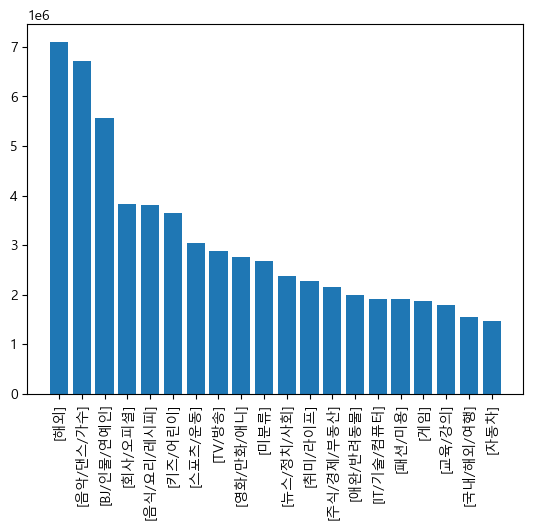

In [307]:
# 시각화 하기
# 막대그래프로 시각화하면 잘보일듯
plt.bar(
    cate_mean_sort.index,
    cate_mean_sort.values
)
plt.xticks(rotation=90)
plt.show()

- 해외 카테고리의 구독자 수의 평균이 가장 높다
- 자동차 카테고리의 구독자 수의 평균이 가장 낮다

In [308]:
# 카테고리별 데이터중 해외 카테고리와 음악/댄스/가수의 카테고리가 유의미한 차이가 있는지 확인하고 싶다.

In [228]:
# 조회수와 비디오 수의 상관계수를 구하기
youtube_df[["video","subscriber_int"]].corr()

,video,subscriber_int
video,1.000000,0.020765
subscriber_int,0.020765,1.000000


# 카테고리 별 평균 비교하기

In [335]:
# 비교할 집단 구분하기
oversea = youtube_df[youtube_df["cate"] == "[해외]"]
sing = youtube_df[youtube_df["cate"] == "[음악/댄스/가수]"]
car = youtube_df[youtube_df["cate"] == "[자동차]"]

In [328]:
stats.shapiro(youtube_df["subscriber_int"])

ShapiroResult(statistic=np.float64(0.2801872255865884), pvalue=np.float64(3.739660929521358e-52))

In [229]:
# 구독자 수 대비 조회수가 높은 브랜드

- 조회수와 비디오개수의 상관계수가 0.02 이므로 조회수와 비디오의 상관관계가 딱히 없다

In [334]:
# 데이터의 등분산성 검정
stats.bartlett(oversea["subscriber_int"],sing["subscriber_int"])

BartlettResult(statistic=np.float64(5.402613574808827), pvalue=np.float64(0.02010662032747941))

- 해외 카테고리와 음악/댄스/가수의 카테고리가 유의미한 차이가 있다!
- 퍼짐정도가 다르다! 라는것을 알수있음

In [337]:
# 그렇다면 1위와 꼴지를 비교해보자
stats.bartlett(oversea["subscriber_int"],car["subscriber_int"])

BartlettResult(statistic=np.float64(14.7155489468214), pvalue=np.float64(0.00012501110253935246))

- 1위 2위를 비교했을때 보다 더 유의미한 차이가 있다!

In [345]:
eda_df_2

,cate,subscriber_int
0,[BJ/인물/연예인],124000000
1,[음악/댄스/가수],99200000
2,[음악/댄스/가수],81600000
3,[음악/댄스/가수],78900000
4,[미분류],76400000
...,...,...
995,[뉴스/정치/사회],990000
996,[영화/만화/애니],990000
997,[미분류],990000
998,[미분류],990000


In [348]:
statistic, pvalue = stats.f_oneway(
    oversea["subscriber_int"], # 1위
    car["subscriber_int"], # 2위
)
# 그래서 결론적으로 내가 얻어내고 싶은 데이터는 무엇임???
# 대립가설 부터...예... 

In [349]:
# 재구조화 하는 이유는 (melt) 컬럼의 값이 인스턴스로 활용되었으면 좋겠어서 그런거임

# 1위 2위 3위를 분석해보자요

# 일원분산분석
statistic, pvalue = stats.f_oneway(
    oversea["subscriber_int"],
    sing["subscriber_int"],
    car["subscriber_int"],
)


print(f"일원분산 분석 결과: F={statistic:.1f}, p={pvalue:.5f}")



일원분산 분석 결과: F=0.3, p=0.71376


- p-value 값이 0.05 보다 크므로 3의 일원분산분석시 분산의 값이 딱히 차이나지 않음을 알수있다.

In [347]:
model = ols("subscriber_int ~ C(cate)", eda_df_2).fit() # R과 비슷까리하게 생겼음! 종속~독립(일본만화처럼읽으면됨)
print(anova_lm(model))

             df        sum_sq       mean_sq         F    PR(>F)
C(cate)    19.0  2.556218e+15  1.345378e+14  2.308798  0.001185
Residual  980.0  5.710636e+16  5.827180e+13       NaN       NaN


# 시나리오
- 나는 1000위 유튜버다
- 1 ~ 500위(상위권)과 차이가 무엇인지 알고 싶고 개선할점을 분석하고 싶다
- 구독자수, 비디오수, 카테고리를 비교했을때 가장 차이가 나는것은 무엇인가?

In [193]:
# 1000위와 1위를 비교한다
upper_group = youtube_df.loc[:499]

In [194]:
upper_group

,cate,title,subscriber,view,video,subscriber_int,view_int
0,[BJ/인물/연예인],김프로KIMPRO,1억2400만,1145억9102만,3594,124000000,1.145910e+11
1,[음악/댄스/가수],BLACKPINK,9920만,403억6448만,637,99200000,4.036448e+10
2,[음악/댄스/가수],BANGTANTV,8160만,260억5213만,2930,81600000,2.605213e+10
3,[음악/댄스/가수],HYBE LABELS,7890만,420억4296만,2896,78900000,4.204296e+10
4,[미분류],Justin Bieber,7640만,363억0715만,278,76400000,3.630715e+10
...,...,...,...,...,...,...,...
495,[IT/기술/컴퓨터],밝은 면 Bright Side Korea,183만,6억6493만,7889,1830000,6.649300e+08
496,[미분류],War Thunder. Official channel.,182만,10억3543만,2253,1820000,1.035430e+09
497,[스포츠/운동],힙으뜸,182만,8억0492만,870,1820000,8.049200e+08
498,[TV/방송],한문철 TV,182만,31억1678만,31049,1820000,3.116780e+09


In [220]:
upper_group.sort_values("subscriber_int",ascending=False)["cate"][0] # 상위권 유튜버의 카테고리 1위

'[BJ/인물/연예인]'

In [195]:
lower_group = youtube_df.iloc[500:]

In [196]:
lower_group

,cate,title,subscriber,view,video,subscriber_int,view_int
500,[패션/미용],Wishtrend TV,182만,1억9334만,1380,1820000,1.933400e+08
501,[뉴스/정치/사회],펜앤마이크TV,182만,4억5114만,4039,1820000,4.511400e+08
502,[뉴스/정치/사회],MBC 라디오 시사,181만,20억7058만,28022,1810000,2.070580e+09
503,[음악/댄스/가수],Rock Music,181만,11억7017만,14535,1810000,1.170170e+09
504,[뉴스/정치/사회],뉴스타파 Newstapa,180만,6억5547만,5478,1800000,6.554700e+08
...,...,...,...,...,...,...,...
995,[뉴스/정치/사회],뉴스데일리베스트,99만,3억1520만,4455,990000,3.152000e+08
996,[영화/만화/애니],구불,99만,2억9263만,391,990000,2.926300e+08
997,[미분류],Again 가요톱10 : KBS KPOP Classic,99만,10억9400만,10688,990000,1.094000e+09
998,[미분류],뚜식이,99만,8억0500만,923,990000,8.050000e+08


In [219]:
lower_group.sort_values("subscriber_int",ascending=False)["cate"][500] # 하위권 유튜버의 카테고리 1위

'[패션/미용]'

In [226]:
diff_df = pd.concat([first,me])
diff_df.set_index("title")

,cate,subscriber,view,video,subscriber_int,view_int
title,,,,,,
Wishtrend TV,[패션/미용],182만,1억9334만,1380,1820000,193340000.0
슈뻘맨 [슈퍼 뻘짓 도전기],[미분류],99만,5억7939만,812,990000,579390000.0


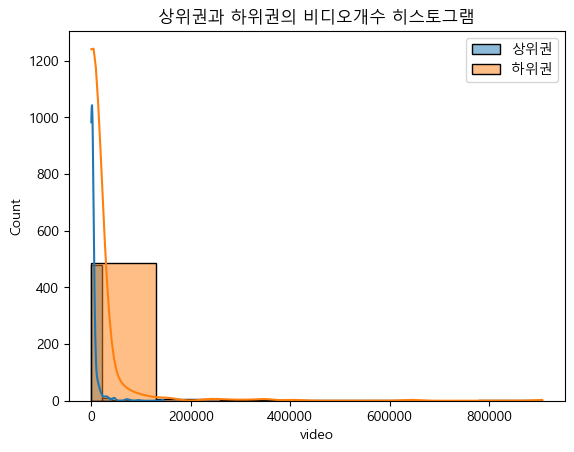

In [242]:
# 비디오 개수 차이
ax = plt.subplots()


ax = sns.histplot(
    lower_group["video"], 
    kde = True, # 밀집도 그래프 포함
    alpha = 0.5,
    bins = 7,
    label = "상위권"
) 


ax = sns.histplot(
    upper_group["video"], 
    kde = True, # 밀집도 그래프 포함
    alpha = 0.5,
    bins = 7,
    label = "하위권"
) 
plt.title("상위권과 하위권의 비디오개수 히스토그램")
plt.legend()
plt.show()

## 카테고리별 채널 수, 구독자 수 분석

In [247]:
# 카테고리별 채널 수
pivot_casub = youtube_df.pivot_table(index = "cate", values = "subscriber_int", aggfunc = ["sum", "count"])

In [248]:
pivot_casub.head()

,sum,count
,subscriber_int,subscriber_int
cate,,
[BJ/인물/연예인],333960000,60
[IT/기술/컴퓨터],11510000,6
[TV/방송],284730000,99
[게임],78670000,42
[교육/강의],32330000,18


In [249]:
pivot_casub.columns

MultiIndex([(  'sum', 'subscriber_int'),
            ('count', 'subscriber_int')],
           )

In [254]:
# 내립차순 정렬
pivot_casub = pivot_casub.sort_values(by=('sum', 'subscriber_int'),ascending = False)

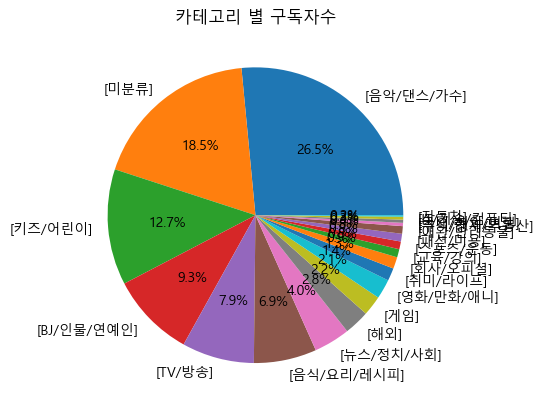

In [255]:
# 구독자 수 파이차트
plt.figure()
plt.pie(pivot_casub[(  'sum', 'subscriber_int')], labels = pivot_casub.index, autopct = "%.1f%%")
plt.title("카테고리 별 구독자수")
plt.show()

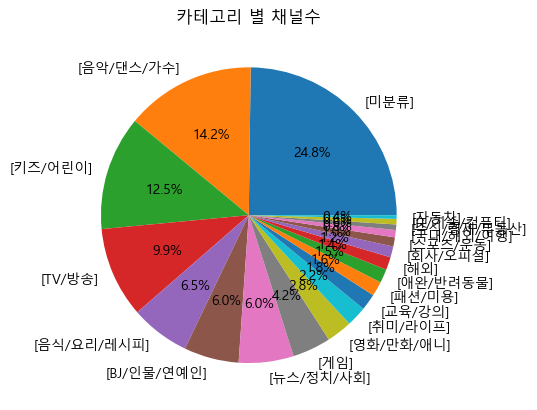

In [257]:
pivot_casub = pivot_casub.sort_values(by=('count', 'subscriber_int'),ascending = False)
plt.figure()
plt.pie(pivot_casub[('count', 'subscriber_int')], labels = pivot_casub.index, autopct = "%.1f%%")
plt.title("카테고리 별 채널수")
plt.show()